# Data Modeling 

### In this notebook, we move forward with our cleaned data and start our preprocessing and modeling 


After cleaning our data, and determining what preprocessing steps we want to integrate into our code via pipelines, we then create our baseline models. Through an iterative process we work through better performing modeling types before using a combination of high performing models. In evaluating these models, we kept in mind that simply guessing the waterpoint is functioning each time will give you a model that performs with 54% accuracy. As we began modeling, it became very clear that non-parametric models were the best fit for our data, as they better tolerate a large proportion of categorical features. As we iterated through the models, this assumption was backed up by our results. 


In [1]:
#Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings

warnings.filterwarnings('ignore')

# settings to display all columns
pd.set_option("display.max_columns", None)

In [29]:
df = pd.read_csv('data/data_cleaned.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_cleaned.csv'

We can take a look again at our final cleaned dataset.

In [3]:
df.head()

,id,non_functional,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,ward,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type_group
0,69572,0,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,Mundindi,109,VWC,Unknown,1999.0,gravity,user-group,pay annually,good,enough,spring,groundwater,communal standpipe
1,8776,0,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,Serengeti,Natta,280,Other,True,2010.0,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,34310,0,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,Simanjiro,Ngorika,250,VWC,True,2009.0,gravity,user-group,pay per bucket,good,enough,dam,surface,communal standpipe
3,67743,1,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,Nanyumbu,58,VWC,True,1986.0,submersible,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe
4,19728,0,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,Karagwe,Nyakasimbi,0,Unknown,True,NaN,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe


## Modeling 

Because of the large number of categorical features in our dataset, we will choose model types that have high functionality with categories. 



First we start with selecting our X and y

In [4]:
X = df.drop(columns='non_functional')
y = df['non_functional']

For preprocessing purposes, we have to split our features into three different groups. One group holds our numerica data. The next deals with categorical columns that have less than 25 unique values. FInally, out last column deals with any categorical columns that have 25 or more unique values. 

In [5]:
#Lists to hold column names
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

Our deliverable to our stakeholders is the final model. With this in consideration, we decided to separate off a holdout set of values before modeling to use on our best model. After this first separation we proceed with a traditional train test split.

In [12]:
#First holdout set
X_train_big, X_holdout, y_train_big, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
#Performing train test split on the remaining data
X_train, X_test, y_train, y_test = train_test_split(X_train_big, y_train_big,
                                                    test_size = .25, random_state = 396)



In [7]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
Function takes in estimator, training data, test data, a Boolean value indicating if the estimator is a grid search, 
and the cross validation splitting strategy if the estimator is not a grid search, 
and returns the accuracy, precision, recall, f1, and the ROC-AUC scores for the model 
and a confusion matrix visualization.  

If ‘grid_search parameter is set to “True” then the function will not perform cross validation on the model. 
Based off of Lindsey Berlin’s evaluate function found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices
- grid_search – “ Boolean indicating whether a the estimator is a GridSearchCV object, 
        if set to “False” a cross validation will be performed with the number of iterations set by the “cv” parameter.  
        Default value is “False”.

Returns – nothing is returned 


    '''
    #If no grid search is being performed, go through evaluation steps as normal, including cross validation
    if grid_search == False:
        #Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        #Printing out the mean of all of our evaluating metrics across the cross validation. 
        #Accuracy, precisionc recall, f1, and roc auc
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    #If a grid search is being performed, do not perform a cross validate.
    else:
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train 
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

Our preprocessing involved splitting our data into three different categories; numerical, small categorical, and large categorical. The preprossing steps for each group was as follows: 

- **Numeric Columns**
Our numerical columns were first run through an Iterative Imputer to deal with missing values by modeling each feature with missing values as a function of other features. We then use a MinMaxScaler on all numeric data to better scale our non normal distributions. 

- **Small Categorical Columns**
Our small categorical columns were run through OneHotEncoder to split each unique value into its own binary column. Columns in this category were selected due to having less than 25 unique values in their column.

- **Large Categorical Columns**
Our large categorical columns were run through a categorical encoder called Count Encoder. This was done because of their large number of unique values. The Count Encoder keeps a single column and reduces the categories in the column to their value counts. 

- **All Categorical Columns**
Alternatively we explored the use of [catboost encoding](https://contrib.scikit-learn.org/category_encoders/catboost.html) for all of our categorical encoders. 


Our first step in our modeling process is to set up some pipelines to deal with our data. 

In [8]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories


num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

#We created category that would use catboost for all categorical features for further evaluation.

all_cat_col_pipe = Pipeline(steps = [
    ('catboost', CatBoostEncoder(random_state=396))
])

Our next step is to create preprocessors that will easily streamline the handling of our data for use in future pipelines. 

In [9]:
#Preprocessor1 makes a distinction between our small and large categorical columns 
preprocessor1 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])
#Preprocessor2 takes in all categorical features no matter the size and handles them using CatBoostEncoder
preprocessor2 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('cat', all_cat_col_pipe, [*sm_cat_cols, *lg_cat_cols]),
])

## Baseline Evaluation

To get an initial understanding of what a modelless prediction looks like, we used DummyClassifier. Our most frequent value in our predictor column is `functioning`. If we were to predict functioning on our test dataset, we would be right around 54% of the time. Any model we create moving forward should outperform this baseline.

Results of Cross-Validation:

Average accuracy: 0.5431494883953081        +/- 4.9912652857475586e-05
Average precision: 0.0        +/- 0.0
**Average recall: 0.0        +/- 0.0
Average f1 score: 0.0        +/- 0.0
Average roc_auc: 0.5        +/- 0.0

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5431494883953082
Train precision: 0.0
**Train recall: 0.0
Train f1 score: 0.0
Train roc_auc: 0.5

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5414389458710789
Test precision: 0.0
**Test recall: 0.0
Test f1 score: 0.0
Test roc_auc: 0.5


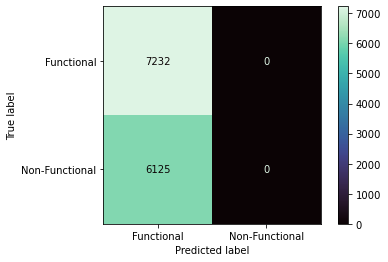

In [10]:
#Pipeline for preprocessing and modeling
baseline_evaluation = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

#Putting our model through our evaluate function
evaluate(baseline_evaluation, X_train, X_test, y_train, y_test, cv=5)

**Results**

- After evaluating our baseline model, we see that it has an accuracy of 54% on the testing data. All other evaluating metric scores are 0 and our roc_auc shows a value of .5, confirming this is a poor model.

# Parametric vs. Non-parametric Modeling

As we move forward in our modeling, we want to make an initial evaluation of parametric and non-parametric models against one another to provide direction for future modeling decisions. We will compare a logistic regresison model to a decision tree model. We expect the non-parametric decision tree to perform better because it is well equiped to handle categorical data. 

## Logistic Regression Model



In [11]:
#Pipeline for preprocessing and modeling
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression(random_state=396))
])

#Putting our logistic regression model through our evaluate function
evaluate(logreg, X_train, X_test, y_train, y_test, cv=5)

KeyboardInterrupt: 

**Results**
- Our baseline logistic regression shows a significant improvement over our dummy classifier model in every single metric used to evaluate.
- While our accuracy and precision scores are high, our recall score is unacceptably low at 58%, as expected. 

## Decision Tree

In [ ]:
#Pipeline for preprocessing and modeling 
dt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

#Putting our decision tree baseline through our evaluate function
evaluate(dt, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Our decision tree model performed better than our baseline model in every metric of evalauation. It also is performing better than our logistic regression model in all areas on our test set as well. It is worth noting that this model is overfit on the training data but it stills performs better than previous models on the testing data.

# Further Non-parametric Modeling 

Because our initial Decision Tree performs better than Logistic Regression across all metrics, we will continue moving forward with non-parametric modeling. 

## Random Forest

We found that a single decision tree gave us a significant improvement in results. To move forward, we will start working with Random Forest which uses multiple decision trees in its modeling. We will also compare our different preprocessing options to see if there are any differences in results.

Results of Cross-Validation:

Average accuracy: 0.8152732717743948        +/- 0.0023299106597422107
Average precision: 0.82439132524158        +/- 0.0042771856420080285
**Average recall: 0.7569648997783329        +/- 0.009397070290811993
Average f1 score: 0.7891869362345965        +/- 0.0038763126085326854
Average roc_auc: 0.8927354780665431        +/- 0.0026139743500277843

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8213670734446358
Test precision: 0.831648039737449
**Test recall: 0.7653877551020408
Test f1 score: 0.797143342968883
Test roc_auc: 0.8170827049846489


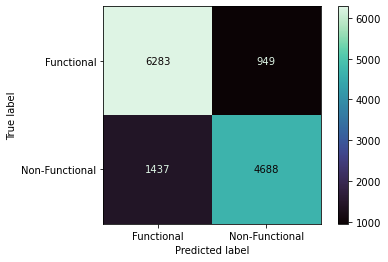

In [20]:
#Pipeline for preprocessing and modeling 
rf1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])
#Putting our random forest through our evaluate function
evaluate(rf1, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Random Forest is performing better than a single decision tree on all metrics. 
- Like the decision tree, this model is also overfit on the training data but performs well on tetsing data.
- **Note:** Not presented in this notebook is further hyper parameter tuning to try to improve metric scores. Ultimately the default hyperparameters performed best.

Running the model through our next preprocessor to evaluate differences.

In [ ]:
#Pipeline for preprocessing and modeling
rf2 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('classifier', RandomForestClassifier(random_state=396))
])
#Putting our random forest with preprocessor2 through our evaluate function
evaluate(rf2, X_train, X_test, y_train, y_test, cv=5)

**Results**
- The catboost encoding did not lead to an increase in model performance in any metric despite reducing overfitting.

## Adaboost

We decided to explore other non-parametric ensemble methods, beyond random forest. Adaboost is included here because it contributes to our final model.  

Results of Cross-Validation:

Average accuracy: 0.7425505365610181        +/- 0.0020524966503570824
Average precision: 0.7826496859289831        +/- 0.002568299028029076
**Average recall: 0.6043366161486947        +/- 0.008711668399694745
Average f1 score: 0.6819818881130233        +/- 0.0047932498237161485
Average roc_auc: 0.8179611192303629        +/- 0.0031703788693464015

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7428000998253057
Train precision: 0.7805049088359046
**Train recall: 0.6079973779088823
Train f1 score: 0.6835349751274336
Train roc_auc: 0.7320909514061963

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7429063412442913
Test precision: 0.7821346194170685
**Test recall: 0.6089795918367347
Test f1 score: 0.6847806131815677
Test roc_auc: 0.7326562782192523


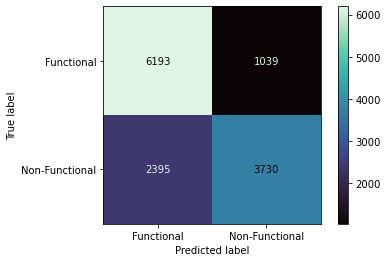

In [18]:
#Pipeline for preprocessing and modeling
adbst = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier(random_state=396))
])

#Putting adaboost through our evaluate function
evaluate(adbst, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Due to the significant drop in recall score, adaboost on it's own was discarded as a standalone potential final model.

- We performed a gridsearch on a few of our models in notebooks foudn in personal folders. The results were subpar and not fit for inclusion in our final model.

- Other Model types were examined, please reference personal notebooks.

## Voting Classifier - Final Model

Preprocessing the data

Setting up Voting Classifier

In [21]:
w_avg = VotingClassifier(estimators=[
    ('ada', adbst),
    ('rndfor', rf1)],
    weights=[0.25, 0.75], voting = 'soft')

Results of Cross-Validation:

Average accuracy: 0.8150985774893936        +/- 0.002682543907518888
Average precision: 0.8227747359439732        +/- 0.004185907317656219
**Average recall: 0.7587676113121151        +/- 0.009549252654216177
Average f1 score: 0.7894244284090602        +/- 0.004210308386576149
Average roc_auc: 0.893114859110214        +/- 0.002597691013057002

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8209178707793666
Test precision: 0.8298285916239618
**Test recall: 0.7666938775510204
Test f1 score: 0.7970128988458927
Test roc_auc: 0.8167678458551563


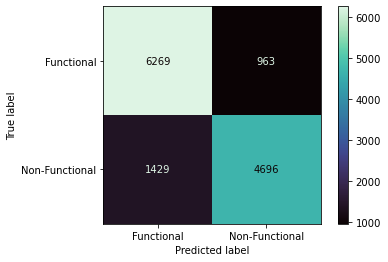

In [25]:
evaluate(w_avg, X_train, X_test, y_train, y_test, cv=5)

Final Model Decision

Testing on Holdout Set

Conclusion